# Online Joint State and Parameters Estimation for HAR SSM
State space model
\begin{align*}
    &\theta_{t}^{(1)} = A(\theta_t^{(2)})\theta_{t-1}^{(1)} + \mathbf{c}v^{(1)}_t  \quad v^{(1)}_t \sim \mathcal{N}\Bigl(0, \frac{1}{\gamma^{(1)}}\Bigr) \\
    &\theta_t^{(0)} = A(\theta_{t}^{(1)})\theta_{t-1}^{(0)} + \mathbf{c}v^{(0)}_{t} \quad v^{(0)}_t \sim \mathcal{N}\Bigl(0, \frac{1}{\gamma^{(0)}}\Bigr) \\
    &y_t = \mathbf{c}^{\top} \theta_t^{(0)} + w_t \quad w_t \sim \mathcal{N}(0, \gamma_y^{-1}) 
\end{align*}

Probabilistic model
\begin{align}
  p&(\Theta, \mathbf{y}, \gamma) = \prod_{t=1}^{T}\underbrace{p(y_t|\theta^{(0)}_t, \gamma_y)}_{\text{observation}}\prod_{i=0}^{N}\underbrace{p(\theta_t^{(i)}|\theta_{t}^{(i+1)}, \theta_{t-1}^{(i)}, \gamma^{(i)})}_{\text{state transition}}\underbrace{p(\theta_0^{(i)})p(\gamma^{(i)})p(\gamma_y)}_{\text{priors}}  \\
    p&(y_t|\theta^{(0)}_t, \gamma_y) = \mathcal{N}\Bigl(y_t|, \mathbf{c}^{\top} \theta_t^{(0)}, \gamma_y^{-1} \Bigr) \\
  p&(\theta_t^{(i)}|\theta_t^{(i+1)}, \theta_{t-1}^{(i)}, \gamma^{(i)}) = \mathcal{N}\Bigl(\theta^{(i)}_t|A(\theta^{(i+1)}_t)\theta^{(i)}_{t-1},  V^{(i)} \Bigr) \label{transition} \\
  p&(\theta_0^{(i)}) = \mathcal{N}(\theta_0^{(i)}|m^{(i)}_{\theta_{0}}, V^{(i)}_{\theta_{0}})  \\ 
  p&(\gamma^{(i)}) = \Gamma(\gamma^{(i)}|\alpha^{(i)}, \beta^{(i)}) 
\end{align}

where
\begin{align*}
    &A(\theta) = 
    \begin{bmatrix}
         \theta^{\top}  \\
         \mathbf{I}_{M-1} \quad \mathbf{0}
    \end{bmatrix}
    \, , \quad
    \mathbf{I}_M = 
    \begin{bmatrix}
        1_1 & 0 &  \dots & 0 \\ 
        0 & 1_2 &  \dots & 0 \\   
        \vdots &  \vdots & \ddots & \vdots \\
        0 & 0  & \dots & 1_{M}
    \end{bmatrix} \, ,\quad
      V^{(i)}= \begin{bmatrix}
            1/\gamma^{(i)} & 0 &\dots & 0 \\ 
            0 & \epsilon & \dots & 0 \\   
            \vdots & \vdots & \ddots & \vdots \\
             0 & 0 & \dots & \epsilon
    \end{bmatrix}
\end{align*}




\begin{align*}
    &\theta^{(i)}_t = (x_t^{(i)}, x_{t-1}^{(i)}, \dots, x_{t-M+1}^{(i)})^{\top} \quad \mathbf{c} = (1, 0, ..., 0)^{\top}
\end{align*}

┌ Info: Recompiling stale cache file /Users/albertpod/.julia/compiled/v1.1/Images/H8Vxc.ji for Images [916415d5-f1e6-5110-898d-aaa5f9f070e0]
└ @ Base loading.jl:1184
┌ Info: Recompiling stale cache file /Users/albertpod/.julia/compiled/v1.1/QuartzImageIO/n8vDP.ji for QuartzImageIO [dca85d43-d64c-5e67-8c65-017450d5d020]
└ @ Base loading.jl:1184


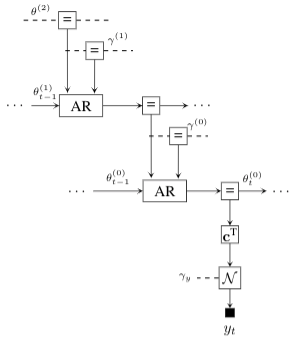

In [1]:
using Images
img = load("../ffgs/HAR-online.png")

In [2]:
using ProgressMeter
using Revise
using Random
using Plots
using LaTeXStrings
using StatsPlots
include("../data/DataAR.jl")
include("../ARNode/ARNode.jl")
include("../helpers/functions.jl")
using .ARNode, .DataAR
using ForneyLab
import LinearAlgebra.I, LinearAlgebra.Symmetric
import ForneyLab: unsafeCov, unsafeMean, unsafePrecision

┌ Info: Recompiling stale cache file /Users/albertpod/.julia/compiled/v1.1/StatsPlots/SiylL.ji for StatsPlots [f3b207a7-027a-5e70-b257-86293d7955fd]
└ @ Base loading.jl:1184


In [61]:
Random.seed!(42)

HARorder = 2

v_θ1 = 0.5
v_x = 100.0

dataHAR = generateHAR(500, HARorder, levels=2, nvars=[v_θ1, v_x], stat=true)
coefs = dataHAR[1]
θ = [θ[1] for θ in dataHAR[2]]
x = [x[1] for x in dataHAR[3]]

# Observations
v_y = 200.0
y = [xi[1] + sqrt(v_y)*randn() for xi in dataHAR[3]];

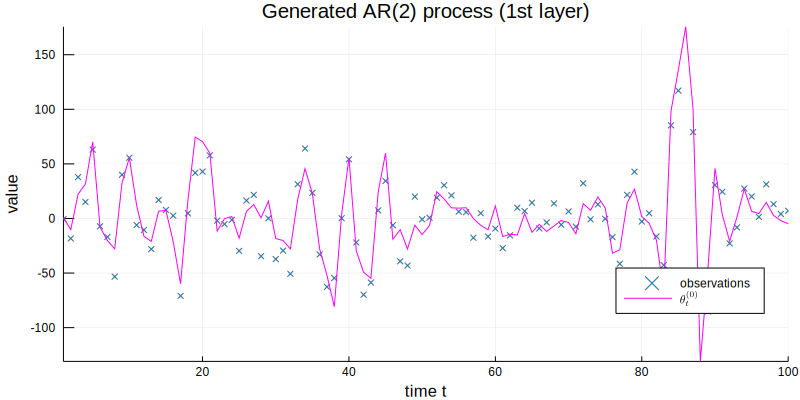

In [64]:
# Plotting the data
from = 1; upto = 100;
plot(xlims=(from, upto), ylims=(minimum(x[from:upto]), maximum(x[from:upto])))
scatter!(y, markershape = :xcross, markeralpha = 0.6,
        markersize = 2, xlabel="time t", ylabel="value", label="observations", legend=:bottomright)
plot!(x, color=:magenta, label=L"\theta^{(0)}_t", title="Generated AR($HARorder) process (1st layer)", size=(800, 400))

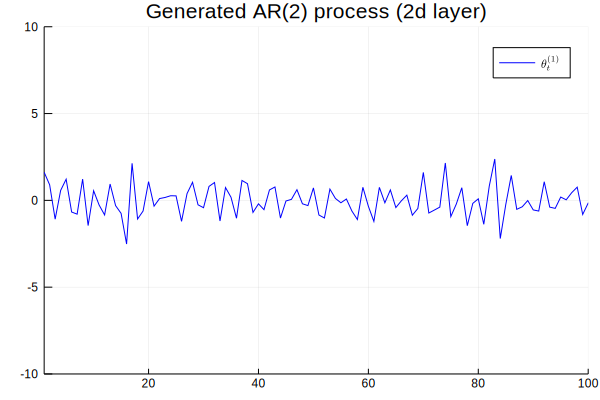

In [65]:
plot(xlims=(from, upto), ylims=(-10, 10))
plot!(θ, color=:blue, label=L"\theta_t^{(1)}", title="Generated AR($HARorder) process (2d layer)")
#savefig("second.png")

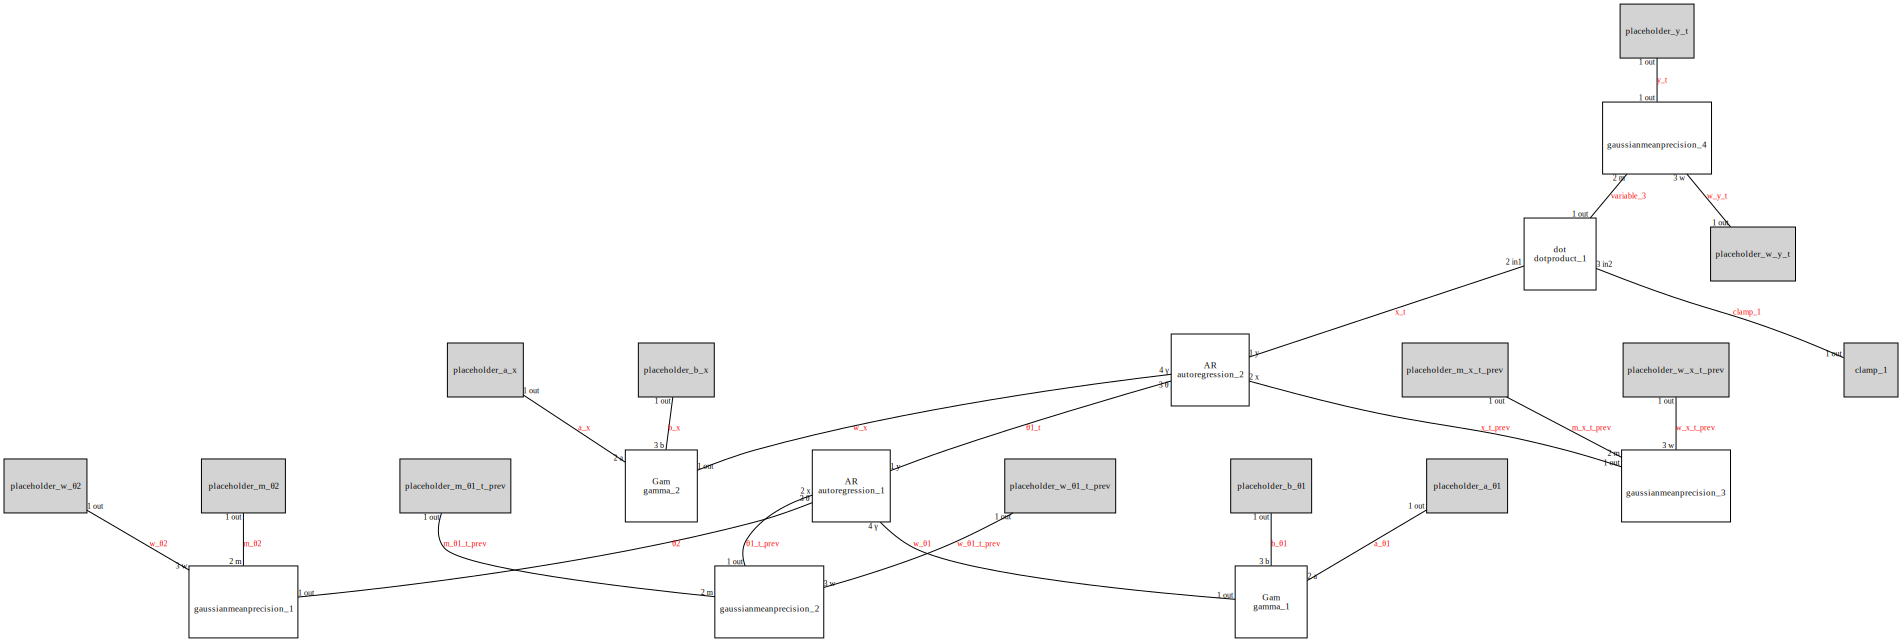

In [66]:
# Creating the graph
g = FactorGraph()

# Upper layer
@RV m_θ2
@RV w_θ2
@RV θ2 ~ GaussianMeanPrecision(m_θ2, w_θ2)
@RV a_θ1
@RV b_θ1
@RV w_θ1 ~ Gamma(a_θ1, b_θ1)
@RV m_θ1_t_prev
@RV w_θ1_t_prev
@RV θ1_t_prev ~ GaussianMeanPrecision(m_θ1_t_prev, w_θ1_t_prev)
@RV θ1_t = AR(θ2, θ1_t_prev, w_θ1)

# Second layer
@RV a_x
@RV b_x
@RV w_x ~ Gamma(a_x, b_x)
@RV m_x_t_prev
@RV w_x_t_prev
@RV x_t_prev ~ GaussianMeanPrecision(m_x_t_prev, w_x_t_prev)
@RV x_t = AR(θ1_t, x_t_prev, w_x)

# Observation
c = zeros(HARorder); c[1] = 1;
@RV y_t ~ GaussianMeanPrecision(dot(c, x_t), placeholder(:w_y_t))

# Placeholders for prior of upper layer
placeholder(m_θ2, :m_θ2, dims=(HARorder,))
placeholder(w_θ2, :w_θ2, dims=(HARorder, HARorder))
placeholder(a_θ1, :a_θ1)
placeholder(b_θ1, :b_θ1)
placeholder(m_θ1_t_prev, :m_θ1_t_prev, dims=(HARorder,))
placeholder(w_θ1_t_prev, :w_θ1_t_prev, dims=(HARorder, HARorder))

# Placeholders for prior of bottom layer
placeholder(a_x, :a_x)
placeholder(b_x, :b_x)
placeholder(m_x_t_prev, :m_x_t_prev, dims=(HARorder,))
placeholder(w_x_t_prev, :w_x_t_prev, dims=(HARorder, HARorder))

# Placeholder for observations
placeholder(y_t, :y_t)

ForneyLab.draw(g)

In [67]:
# Specify recognition factorization
q = RecognitionFactorization(θ1_t, θ2, θ1_t_prev, w_θ1, x_t, x_t_prev, w_x,
                             ids=[:θ1_t :θ2 :θ1_t_prev :W_θ1 :X_t :X_t_prev :W_x])

algo = variationalAlgorithm(q)
algoF = freeEnergyAlgorithm(q)

# Load algorithms
eval(Meta.parse(algo))
eval(Meta.parse(algoF))

freeEnergy (generic function with 1 method)

In [73]:
# Storage for upper layer
m_θ1 = Vector{Vector{Float64}}(undef, length(y))
w_θ1 = Vector{Array{Float64, 2}}(undef, length(y))
m_θ1_prev = Vector{Vector{Float64}}(undef, length(y))
w_θ1_prev = Vector{Array{Float64, 2}}(undef, length(y))
m_θ2 = Vector{Vector{Float64}}(undef, length(y))
w_θ2 = Vector{Array{Float64, 2}}(undef, length(y))
a_θ1 = Vector{Float64}(undef, length(y))
b_θ1 = Vector{Float64}(undef, length(y))

# Storage for bottom layer
m_x = Vector{Vector{Float64}}(undef, length(y))
w_x = Vector{Array{Float64, 2}}(undef, length(y))
a_x = Vector{Float64}(undef, length(y))
b_x = Vector{Float64}(undef, length(y))

# Define values for upper layer
m_θ2_0 = zeros(HARorder)
w_θ2_0 = diageye(HARorder)
a_θ1_0 = 0.00001
b_θ1_0 = 0.00001
m_θ1_prev_0 = zeros(HARorder)
w_θ1_prev_0 = diageye(HARorder)
m_θ1_t_0 = zeros(HARorder)
w_θ1_t_0 = diageye(HARorder)

# Define values for bottom layer
a_x_0 = 0.00001
b_x_0 = 1.0
m_x_t_prev_0 = zeros(HARorder)
w_x_t_prev_0 = tiny*diageye(HARorder)

# Priors upper layer
m_θ2_min = m_θ2_0
w_θ2_min = w_θ2_0
a_θ1_min = a_θ1_0
b_θ1_min = b_θ1_0
m_θ1_t_prev_min = m_θ1_prev_0
w_θ1_t_prev_min = w_θ1_prev_0

# Priors bottom layer
a_x_min = a_x_0
b_x_min = b_x_0
m_θ1_t_min = m_θ1_t_0
w_θ1_t_min = w_θ1_t_0
m_x_t_prev_min = m_x_t_prev_0
w_x_t_prev_min = w_x_t_prev_0;

In [74]:
data = Dict()
marginals = Dict()
n_its = 5

# Storage for scores
FHAR = []
logPDFsHAR = []

p = Progress(length(y), 1, "Observed ")
for t in 1:length(y)
    update!(p, t)
    # Upper Layer
    marginals[:θ2] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=m_θ2_min, w=w_θ2_min)
    marginals[:θ1_t_prev] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=m_θ1_t_prev_min, w=w_θ1_t_prev_min)
    marginals[:θ1_t] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=m_θ1_t_min, w=w_θ1_t_min)
    marginals[:w_θ1] = ProbabilityDistribution(Univariate, Gamma, a=a_θ1_min, b=b_θ1_min)
    # Bottom Layer
    marginals[:x_t_prev] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=m_x_t_prev_min, w=w_x_t_prev_min)
    marginals[:w_x] = ProbabilityDistribution(Univariate, Gamma, a=a_x_min, b=b_x_min)

    global m_θ2_min, w_θ2_min, m_θ1_t_prev_min, w_θ1_t_prev_min, a_θ1_min, b_θ1_min,
           m_θ1_t_min, w_θ1_t_min, m_x_t_prev_min, w_x_t_prev_min, a_x_min, b_x_min, data

    for i = 1:n_its
        data = Dict(:y_t => y[t],
                    :w_y_t => v_y^-1,
                    :m_θ2 => m_θ2_min,
                    :w_θ2 => w_θ2_min,
                    :m_θ1_t_prev => m_θ1_t_prev_min,
                    :w_θ1_t_prev => w_θ1_t_prev_min,
                    :a_θ1 => a_θ1_min,
                    :b_θ1 => b_θ1_min,
                    :m_x_t_prev => m_x_t_prev_min,
                    :w_x_t_prev => w_x_t_prev_min,
                    :a_x => a_x_min,
                    :b_x => b_x_min)

        stepX_t!(data, marginals)
        stepX_t_prev!(data, marginals)
        stepW_x!(data, marginals)
        stepθ1_t!(data, marginals)
        stepθ1_t_prev!(data, marginals)
        stepW_θ1!(data, marginals)
        stepθ2!(data, marginals)

        m_θ1_prev[t] = unsafeMean(marginals[:θ1_t_prev])
        w_θ1_prev[t] = unsafePrecision(marginals[:θ1_t_prev])
        m_θ1[t] = unsafeMean(marginals[:θ1_t])
        w_θ1[t] = unsafePrecision(marginals[:θ1_t])
        m_θ2[t] = unsafeMean(marginals[:θ2])
        w_θ2[t] = unsafePrecision(marginals[:θ2])
        a_θ1[t] = marginals[:w_θ1].params[:a]
        b_θ1[t] = marginals[:w_θ1].params[:b]
        m_x[t] = unsafeMean(marginals[:x_t])
        w_x[t] = unsafePrecision(marginals[:x_t])
        a_x[t] = marginals[:w_x].params[:a]
        b_x[t] = marginals[:w_x].params[:b]

        m_θ2_min = m_θ2[t]
        w_θ2_min = w_θ2[t]
        m_θ1_t_prev_min = m_θ1_prev[t]
        w_θ1_t_prev_min = w_θ1_prev[t]
        m_θ1_t_min = m_θ1[t]
        m_θ1_t_min = m_θ1[t]
        m_x_t_prev_min = m_x[t]
        w_x_t_prev_min = w_x[t]
        a_θ1_min = a_θ1[t]
        b_θ1_min = b_θ1[t]
        a_x_min = a_x[t]
        b_x_min = b_x[t]
    end
    push!(logPDFsHAR, logPDF(x[t], m_x[t][1], w_x[t][1]^-1))
    push!(FHAR, (freeEnergy(data, marginals)))
end

In [75]:
## Plotting AR coefs first layer
# Extracting estimates for x_t (first component of vector x̄_t)
m_xt = [m_x[1] for m_x in m_x]
v_xt = [v_x[1]^-1 for v_x in w_x]

# Extracting estimates for θ2_t (first component of vector θ̂2_t)
m_θ1t = [m_θ1[1] for m_θ1 in m_θ1]
v_θ1t = [v_x[1]^-1 for v_x in w_θ1];

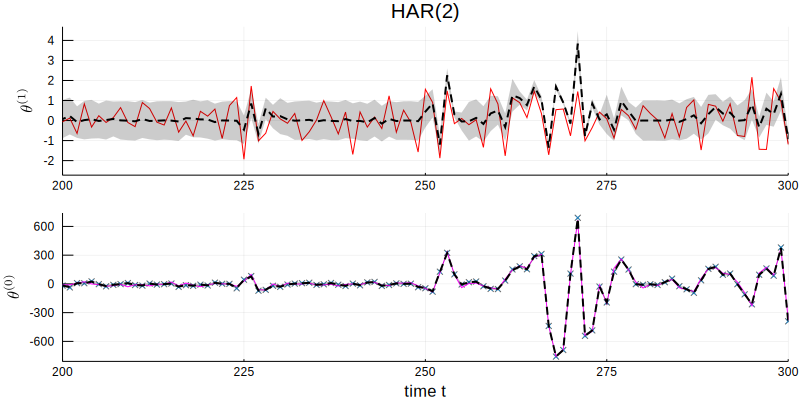

In [78]:
from = 200
upto = 300
scatter(y, markershape = :xcross, markeralpha = 0.6, xlims=(from, upto),
        ylims=(minimum(y[from:upto]) - 50, maximum(y[from:upto]) + 50),
        markersize = 2, xlabel="time t", ylabel=L"\theta^{(0)}", label="observations")
plot!(x, color=:magenta, label="real", title="")
pHAR = plot!(m_xt, ribbon=(sqrt.(v_xt), sqrt.(v_xt)),
      linestyle=:dash, linewidth = 2,
      color=:black,
      fillalpha = 0.2,
      fillcolor = :black,
      label="inferred")

plot(xlims=(from, upto), ylabel=L"\theta^{(1)}")
plot!(θ, color=:red, label="real", title="Inference 2d layer")
pAR = plot!(m_θ1t, ribbon=(sqrt.(v_θ1t), sqrt.(v_θ1t)),
      linestyle=:dash, linewidth = 2,
      color=:black,
      fillalpha = 0.2,
      fillcolor = :black,
      label="inferred", title="HAR($HARorder)")

plot(pAR, pHAR, layout=(2,1), size=(800, 400), legend=false)
#savefig("har.png")

In [82]:
unsafeCov(marginals[:θ2])

2×2 Array{Float64,2}:
  1.0  -0.0      
 -0.0   0.0186544

In [80]:
marginals

Dict{Any,Any} with 8 entries:
  :θ1_t_prev  => 𝒩(xi=[4.76e+02, 0.00], w=[[2.50e+15, 0.00][0.00, 92.05]])…
  :x_t_prev   => 𝒩(xi=[-3.62e+12, -3.62e+12], w=[[1.00e+12, -7.73e-20][-7.73e-…
  :variable_3 => 𝒩(xi=0.01, w=5.07e-03)…
  :x_t        => 𝒩(xi=[0.01, -3.62e+12], w=[[5.07e-03, 0.00][0.00, 1.00e+12]])…
  :θ2         => 𝒩(xi=[3.13e-11, 0.00], w=[[1.00, 0.00][0.00, 53.61]])…
  :w_x        => Gam(a=1.25e+03, b=1.71e+07)…
  :θ1_t       => 𝒩(xi=[-6.82e-04, 0.19], w=[[1.02, 9.56e-04][9.56e-04, 1.00e+1…
  :w_θ1       => Gam(a=1.25e+03, b=1.22e+03)…